<a href="https://colab.research.google.com/github/michalis0/MGT-502-Data-Science-and-Machine-Learning/blob/main/07_Recommenders/Lab_12_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install surprise

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
import os
os.environ["OMP_NUM_THREADS"] = '1'
import pandas as pd
import io
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import time
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from collections import defaultdict

# ML import
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as shc
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from IPython.display import Image, display, HTML

# Import from surprise library
from surprise import Dataset
from surprise import get_dataset_dir
from surprise import KNNBasic, KNNWithMeans, SVD
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate, GridSearchCV
from surprise import Reader, accuracy

# Set some formatting options
np.set_printoptions(threshold=500, precision=4)
pd.options.display.max_seq_items = 20
pd.options.display.max_rows = 20

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# MOVIE STREAMING SERVICE: CLUSTERING, ASSOCIATION RULES, RECCOMENDER SYSTEM

We will implement clustering, association rules, and recommender systems algorithms, applying these methods to:
- explore the similarities within groups of people watching movies (clustering analysis)
- discover the relations between movies genre (association rules)
- recommend movies to users (recommender system)

We will use the MovieLens dataset, which contains movie ratings collected from the MovieLens website by the [GroupLens](https://grouplens.org/) research lab.

Source: F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. *ACM Transactions on Interactive Intelligent Systems (TiiS)* 5, 4: 19:1–19:19. <https://doi.org/10.1145/2827872>



## Clustering analysis: similarities between people

In this section, you will try to form clusters of individuals based on their preferences regarding movie genres. You will use a transformed version of the MovieLens dataset containing, for a selection of users:
- their average rating of all science fiction movies they rated,
- their average rating of all comedy movies they rated.

Better understanding the differences in people's tastes can help improve the design of recommender systems, for instance for the creation of the user neighborhood. Ok, let's start!

- Load the data in a dataframe. The url link is provided below. Display the first 10 observations.

In [5]:
url_clustering = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/ratings_clustering.csv'
df_movies= pd.read_csv(url_clustering)
df_movies.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,avg_scifi_rating,avg_comedy_rating
0,3.50,2.71
1,2.56,2.64
2,2.00,3.20
3,3.18,2.83
4,3.00,3.90
5,2.33,3.20
6,3.00,3.63
7,2.30,3.40
8,3.11,3.39
9,2.85,2.47


The first 10 rows reveal the structure of the dataset at hand, which appears to be very simple: the two columns represent the average rating for scifi movies and comedies for many different users. The information is therefore very limited (only average rating on two genres, we have no other data about users' tastes), which can be both a drawback and an advantage for the future analysis.

An obvious drawback is that the results might not be as accurate and useful as in case if we had more specific data. For example, average rating of thrillers, animation films, musicals, drama, etc. Or even user-specific information, like age, gender, country of origin and favourite actors.

Yet, there are advantages to having to work with only two columns of data. The main advantage is the simplicity of such an analysis. We can easily plot the two-dimentional data (would be harder to visualize and interpret the results if we had ratings for 10 genres), we can identify simple patterns and the computation time will be reduced.

- Plot a dendogram using "ward" as linkage method and "euclidean" as metric.
- Based on the dendogram, how many clusters do you think is optimal? Briefly justify your answer.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


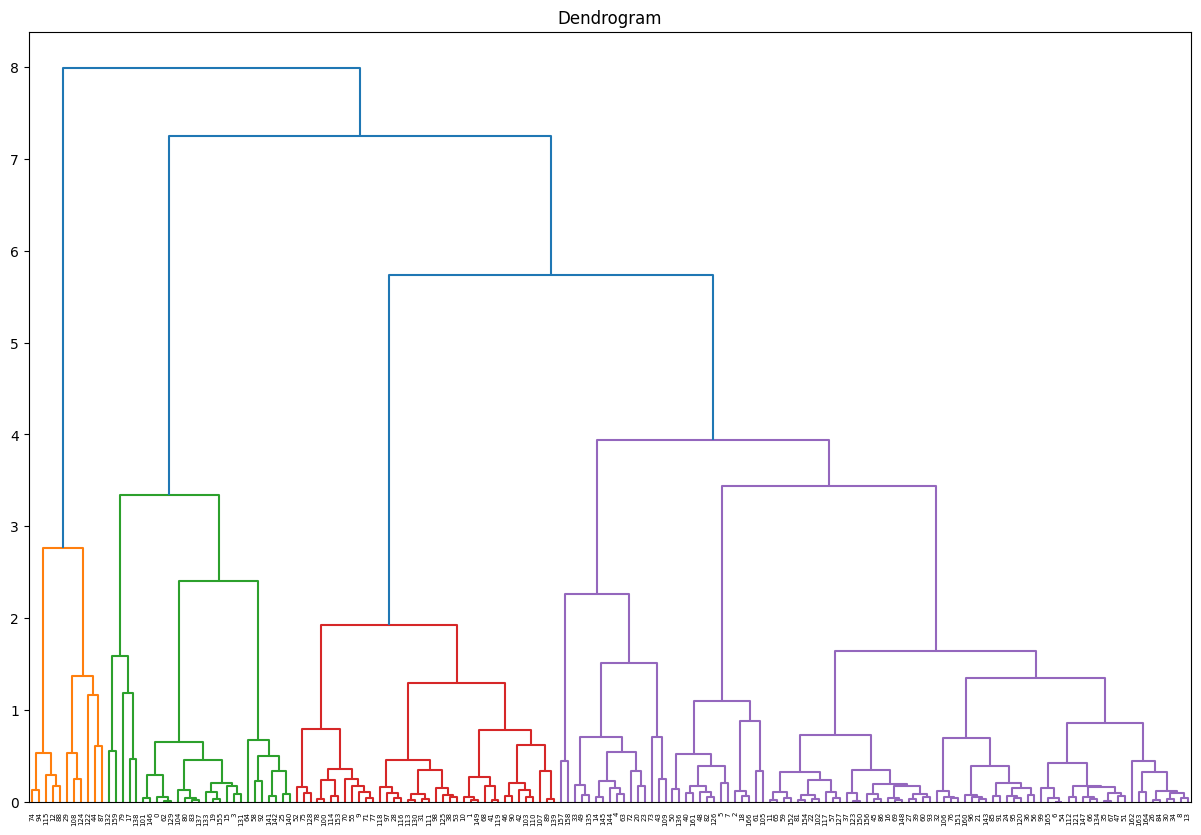

In [6]:
plt.figure(figsize=(15, 10))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(df_movies, method='ward', metric='euclidean'))
plt.show()

The dendrogram above serves as an illustration of hierarchical relationships between data elements and sets of data within the given sample. It can be observed that the dendogram gets more and more complex as it descends, meaning that larger clusters are being split into smaller ones.

If we draw a line in the upper part of the dendrogram, we will obtain fewer clusters with more general characteristics dividing elements into them. Conversely, if we draw a line in the lower part of the dendrogram, we will obtain more clusters defined by more detailed and elaborate sets of characteristics.

There is no sure-fire way to identify the best number of clusters. A rule of thumb is that too many is bad because it can lead to overfitting, and too few is bad because such division would not be useful and informative enough. Therefore, I would draw a line right before different colors emerge on the dendrogram, namely, at the height 4.5.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


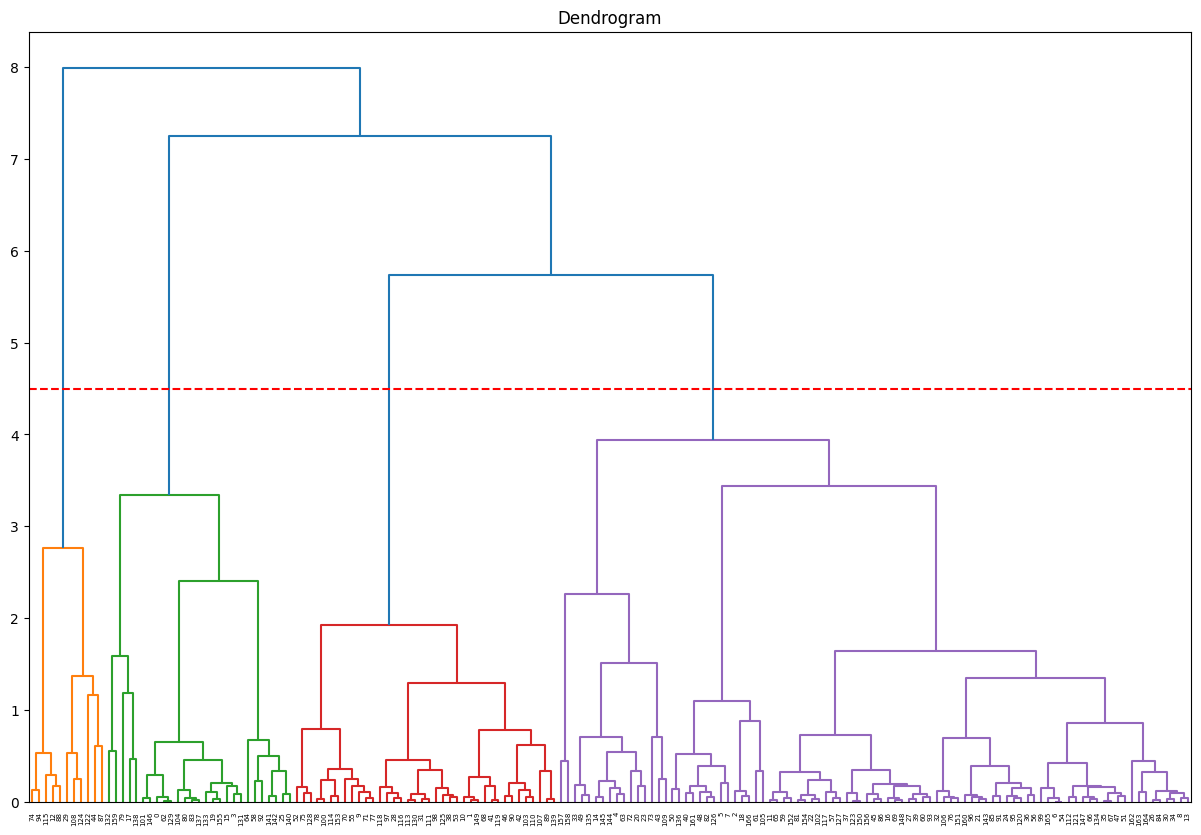

In [7]:
plt.figure(figsize=(15, 10))
plt.title("Dendrogram")
dend = shc.dendrogram(shc.linkage(df_movies, method='ward', metric='euclidean'))

# Add a horizontal line to the dendrogram
plt.axhline(y=4.5, color='r', linestyle='--')

plt.show()

The red line drawn at the height 4.5 crosses 4 "branches" of the dendrogram, meaning that by cutting at this level we obtain 4 clusters. Is it an optimal number of clusters? We cannot say. Maybe drawing a line slightly lower or higher would be more useful.

I based my choice on my subjective perception of the task at hand. Here are my main assumptions:
* Since the dataset contains ratings of movies by the users, our main goal would be segmentation of these users. Too much fragmentation (in other words, too many clusters) would lead to unnecessary complexity.
* Yet, we need to be careful not to pick clusters that are too general to be informative. Tastes of users can be unified, but only to a certain point, past which such unification will no longer be of any use.
* Below 4 on the graph the dendrogram starts to actively branch off, there emerge different colors (done automatically). It seems logical to cut above that point to avoid extra complexity.

One of the ways to check whether the original guess concerning the number of clusters was good or not is to implement the Elbow method.

- Implement the Elbow method to determine the optimum number of cluster for K-Means algorithm (use `random_state=17` as parameter of K-Means).
- Based on the Elbow method, how many clusters do you think is optimal? Briefly justify your answer.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

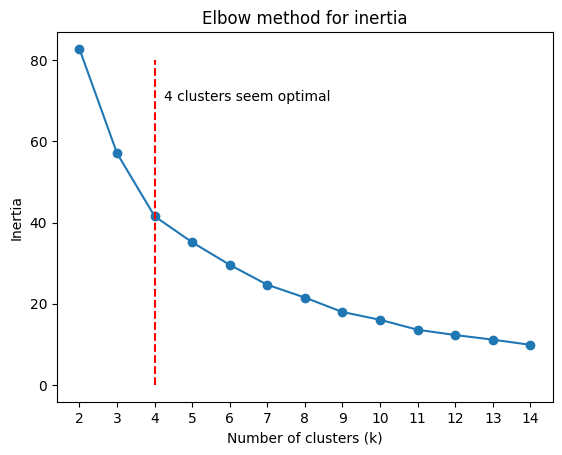

In [8]:
inertias = []
nbr_clusters = range(2,15)

for i in nbr_clusters:
    km = KMeans(n_clusters=i, random_state=17).fit(df_movies)  # Create and fit model
    inertias.append(km.inertia_)     # Store inertia

# Plot
plt.plot(nbr_clusters, inertias, '-o')
plt.xticks(nbr_clusters)
plt.vlines(x=4,ymin=0,ymax=80,linestyles='--', color='r')
plt.text(x=4.25,y=70, s='4 clusters seem optimal', fontsize=10)
plt.title('Elbow method for inertia')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.show()

The graph above illustrates that the original assumption concerning the optimal number of clusters was a good one. Looking at the blue line, we can notice the steep decline in inertia on the segment from 2 to 4 clusters. After 4 clusters the line crawls down slowly, meaning that we do not gain much from adding each extra cluster.

Taking into consideration the explanations given above, I conclude that 4 is a suitable number of clusters that I can use in my analysis.

- Implement (train) a K-Means algorithm with the number of clusters of your choice. Use `random_state=17` as parameter.

In [9]:
kmeans = KMeans(n_clusters=4, random_state=17) #3 clusters
kmeans.fit(df_movies)
print(kmeans.cluster_centers_)

[[1.4776 3.2559]
 [2.835  2.866 ]
 [3.8771 2.4212]
 [2.9287 3.6054]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


The matrix displayed above corresponds to the coordinates of the centers of the 4 clusters. Next we can look at the labels assigned to each of the observations, in other words, - to which cluster each user was attributed.

In [10]:
kmeans.labels_

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([2, 1, 0, 1, 3, 1, 3, 3, 3, 1, 1, 1, 0, 3, 3, 1, 1, 2, 0, 1, 3, 3,
       1, 3, 3, 2, 3, 1, 1, 0, 3, 1, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3,
       0, 3, 1, 3, 3, 3, 3, 3, 1, 1, 3, 1, 3, 1, 2, 1, 3, 0, 2, 3, 2, 1,
       3, 3, 1, 1, 1, 1, 3, 3, 0, 1, 1, 1, 1, 2, 1, 1, 3, 1, 3, 3, 3, 0,
       0, 1, 1, 3, 2, 1, 0, 3, 3, 1, 1, 3, 1, 2, 1, 1, 1, 0, 1, 0, 0, 3,
       1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 3, 3, 0, 1, 0, 1, 3, 1, 1, 2, 1, 1,
       2, 1, 3, 3, 3, 1, 2, 1, 2, 2, 2, 3, 3, 3, 2, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 2, 3, 3, 3, 1, 3, 3, 0], dtype=int32)

This is not the most informative way to present such data. It is confusing and hard to interpret. That is why I decided to plot a scatterplot, where each of the 4 clusters is marked by a different color.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


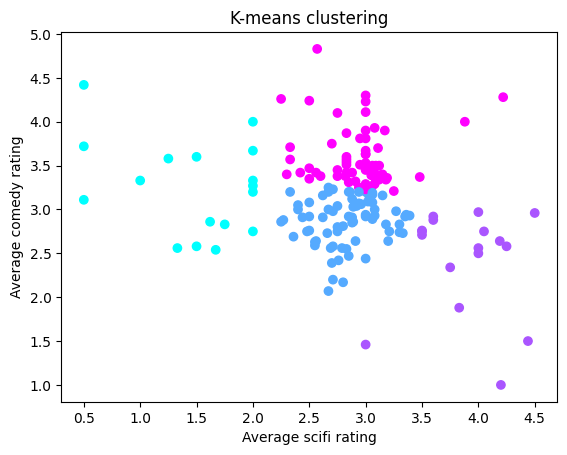

In [11]:
x = df_movies['avg_scifi_rating']
y = df_movies['avg_comedy_rating']
plt.scatter(x, y, c=kmeans.labels_, cmap='cool')
plt.title('K-means clustering')
plt.xlabel('Average scifi rating')
plt.ylabel('Average comedy rating')
plt.show()

Judging by the scatterplot above, we can infer that the algorithm has identified avid scifi fans (purple), those who love to laugh (pale blue), people who rate everyhting well (pink) and those who are very hard to please (dark blue).

Even though it seems like a very clear and accurate way to draw 4 clusters out of the given data elements, it is not the only way.

- Implement (train) a hierarchical algorithm with the same number of clusters as for the K-Means model. Use "ward" as linkage method and "euclidean" as metric/affinity

In [12]:
agglomerative = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')

agglomerative.fit(df_movies)

print(agglomerative.labels_)

[2 3 0 2 0 0 0 0 0 3 3 0 1 0 0 2 0 2 0 2 0 0 0 0 0 2 0 0 3 1 0 3 0 0 0 0 0
 0 3 0 0 3 3 0 1 0 3 0 0 0 0 0 3 3 0 3 0 0 2 0 0 0 2 0 2 0 0 0 3 0 3 3 0 0
 1 3 0 3 3 2 2 0 0 2 0 0 0 1 1 3 3 0 2 0 1 0 0 3 3 0 3 2 0 3 2 0 0 3 1 0 3
 3 0 3 3 1 3 0 3 3 0 0 1 0 1 3 0 0 3 2 3 2 2 2 0 0 0 2 2 3 2 2 2 0 0 0 2 0
 0 3 0 0 0 3 0 2 0 0 0 2 0 0 0 0 0 0 0]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


A different algorithm has assigned different labels to the same data.

As in the previous example, I will create a scatterplot for better visualization.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


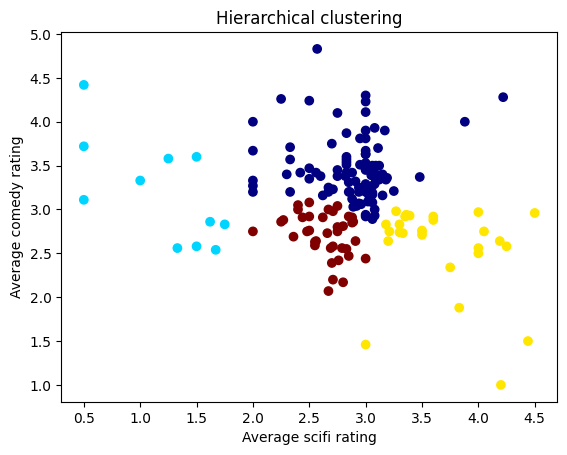

In [13]:
x = df_movies['avg_scifi_rating']
y = df_movies['avg_comedy_rating']
plt.scatter(x, y, c=agglomerative.labels_, cmap='jet')
plt.title('Hierarchical clustering')
plt.xlabel('Average scifi rating')
plt.ylabel('Average comedy rating')
plt.show()

On the face of it, it seems like the clusters are more or less the same. In order to spot the differences, I will compare the two scatterplots drawn next to each other.

- Create a figure consisting of two subplots:
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your KMeans model. Add the cluster centers to your plot. Label your clusters with the name of your choice (e.g., "Comedy aficionado").
    - a scatterplot of 'avg_scifi_rating' and 'avg_comedy_rating' colored by the clusters predicted with your hierarchical algorithm model. Label your clusters with the name of your choice.
- How do your models compare?

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-14-f61b61d6994a>:37: UserWarning: Legend does not support handles for Legend instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  fig.legend([legend1, legend2], ["K-means clustering", "Hierarchical clustering"], loc='right')


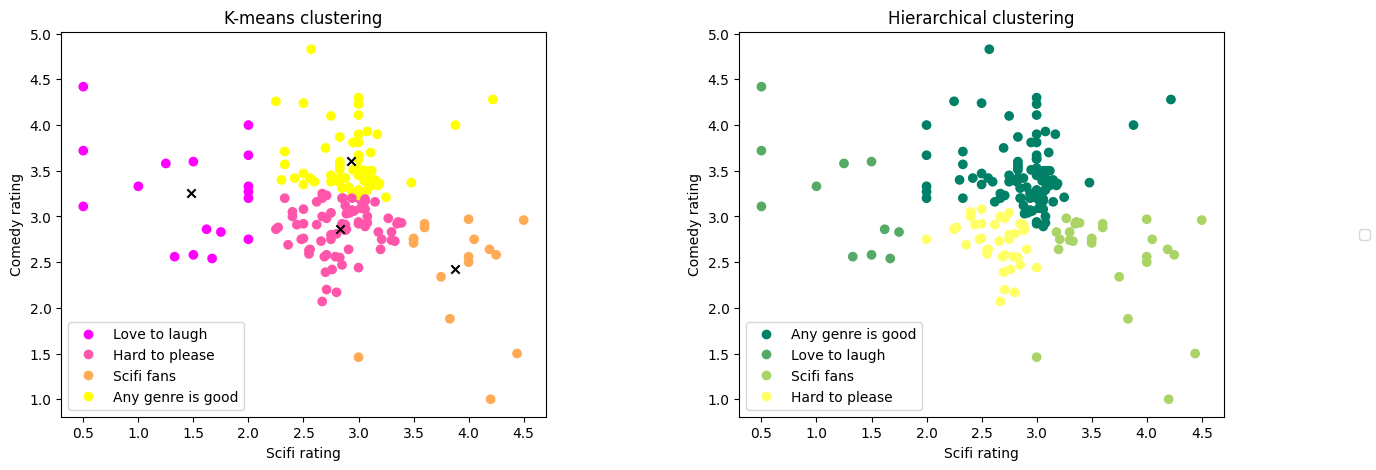

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Scatter plot, K-means
scatter1 = ax[0].scatter(df_movies['avg_scifi_rating'],
                          df_movies['avg_comedy_rating'],
                          c=kmeans.labels_,
                          cmap='spring')
ax[0].scatter(kmeans.cluster_centers_[:, 0],
              kmeans.cluster_centers_[:, 1],
              c="black",
              marker='x')
ax[0].set_xlabel('Scifi rating')
ax[0].set_ylabel('Comedy rating')
ax[0].set_title('K-means clustering')

# Scatter plot of clusters, Hierarchy
scatter2 = ax[1].scatter(df_movies['avg_scifi_rating'],
                          df_movies['avg_comedy_rating'],
                          c=agglomerative.labels_,
                          cmap='summer')
ax[1].set_xlabel('Scifi rating')
ax[1].set_ylabel('Comedy rating')
ax[1].set_title('Hierarchical clustering')

# Add legends
handles1, labels1 = scatter1.legend_elements()
#labels1 = ['Cluster {}'.format(i) for i in np.unique(kmeans.labels_)]
labels1 = ['Love to laugh', 'Hard to please', 'Scifi fans', 'Any genre is good']
legend1 = ax[0].legend(handles1, labels1, loc="best")

handles2, labels2 = scatter2.legend_elements()
#labels2 = ['Cluster {}'.format(i) for i in np.unique(agglomerative.labels_)]
labels2 = ['Any genre is good', 'Love to laugh', 'Scifi fans', 'Hard to please']
legend2 = ax[1].legend(handles2, labels2, loc="best")

# Add legends to the right of the subplots
fig.legend([legend1, legend2], ["K-means clustering", "Hierarchical clustering"], loc='right')

plt.subplots_adjust(wspace=0.4)
plt.show()


An attentive look at the subplots above would allow to spot the slight differences in the way two algorithms drew clusters. Even though the general image looks similar, some dots on the borders of clusters are assigned differently when k-means or hierarchical techniques are used. Yet, these discrepancies are not drastic, and overall we can identify same categories of users on both graphs:

* **'love to laugh'** - those who rate comedies well and do not appreciate scifi genre as much, *left-hand side cluster*;
* **'scifi fans'** - those who have an explicit preference for scifi movies and do not enjoy comedies as much, *right-hand side cluster*;
* **'hard to please'** - the users that leave relatively bad reviews both for comedies and scifi films, *central-lower cluster*;
* **'any genre is good'** - those who like both genres of movies, *central-upper cluster*.

In case of the k-means algorithm, the 'love to laugh' cluster is bigger than in case of hierarchical algorithm. Among the comedy aficionados, identified by the former, the latter attributed 5 users to 'any genre is good' and placed 1 user in the 'hard to please' category.

If we compare 'any genre is good' cluster, we will notice that this cluster is bigger on the second subplot. Same is true for 'scifi fans'. And the 'hard to please' category is bigger in the first subplot.

On the first subplot we see the cluster centers marked with little black crosses.

## Association Rules: association between movie genres

We will now pursue our analysis, but this time trying to dig out information about movies. More precisely, we will search for matches between film genres using association rules. We try to understand, for instance, how likely it is that a film is both drama and action. This information can be interesting for film producers who may either want to produce something similar to the established norm: if most drama films are also action, perhaps the new action-drama film would be equally appreciated, or quite to the contrary try a new combination of genres which is more rare to find.

- Load the data in a dataframe. The url link is provided below.
- Display the first 10 observations.
- Print the unique values of genres from the first column.
- How many unique genres does the first column contain?
- How many movies does the dataframe contain?

In [15]:
url_association_rules = 'https://raw.githubusercontent.com/michalis0/MGT-502-Data-Science-and-Machine-Learning/main/data/movies_assoc_rules.csv'
df_movies2= pd.read_csv(url_association_rules)
df_movies2.head(10)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
0,Adventure,Animation,Children,Comedy,Fantasy,NaN,NaN,NaN,NaN,NaN
1,Adventure,Children,Fantasy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Action,Crime,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Comedy,Romance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Adventure,Children,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Action,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Action,Adventure,Thriller,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
print(df_movies2.iloc[:, 0].unique())

['Adventure' 'Comedy' 'Action' 'Drama' 'Crime' 'Children' 'Mystery'
 'Documentary' 'Animation' 'Thriller' 'Horror' 'Fantasy' 'Western'
 'Film-Noir' 'Romance' 'War' 'Sci-Fi' 'Musical' 'IMAX']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print('There are ', len(df_movies2.iloc[:, 0].unique()), ' movie genres.')

There are  19  movie genres.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
print('There are ', df_movies2.shape[0], ' movies.')

There are  27032  movies.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


- Preprocessing: convert the dataset using a `Transaction Encoder` from the `mlextend` module so that the dataset is reorganised in columns of unique genres. Rows should contain only True or False boolean values according to whether a film was considered as belonging to a genre column or not. Check that you have the correct dimensions.

The first step is to remove the missing values from the dataframe.

In [19]:
movie_list = df_movies2.values.tolist()
movie_list_cleaned = [[x for x in y if str(x) != 'nan'] for y in movie_list]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
# instance of Encoder
te = TransactionEncoder()

# fitting encoder and transform our list
df_movies2_encoded = te.fit(movie_list_cleaned).transform(movie_list_cleaned)

# creating dataframe with results
df_movies2_encoded = pd.DataFrame(df_movies2_encoded, columns=te.columns_)
df_movies2_encoded.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,False,True,True,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False
1,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,False
4,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False
6,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False
7,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [21]:
df_movies2_encoded.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(27032, 19)

The dimentions correspond to the number of movies (rows - 27032) and the number of genres (columns - 19).

###Apriori Algorithm

The Apriori algorithm is a classic algorithm used for association rule mining in data mining and machine learning. It's designed to discover interesting relationships, associations, or patterns within large datasets, particularly in transactional databases such as those found in retail, e-commerce, or basket analysis.

Here's a breakdown of how the Apriori algorithm works:

*   Support: The algorithm starts by calculating the support of itemsets, which is the proportion of transactions in the dataset that contain a particular itemset. The support of an itemset {A, B} is the number of transactions containing both items A and B divided by the total number of transactions.
*    Frequent Itemset Generation: Apriori then generates frequent itemsets by iteratively applying the following two steps:
    *  Join: It generates candidate itemsets of length (k+1) by joining frequent itemsets of length k.
    *  Prune: It prunes the candidate itemsets that do not meet the minimum support threshold. This pruning step is crucial for efficiency, as it eliminates the need to generate and count all possible itemsets.
*   Association Rule Generation: Once frequent itemsets are identified, Apriori generates association rules from them. An association rule is an implication of the form {A} -> {B}, where A and B are itemsets, and the rule indicates that if A occurs, then B is likely to occur as well.
*   Confidence and Confidence Pruning: Apriori calculates the confidence of each association rule. Confidence is the probability of seeing the items in the consequent (B) given that the antecedent (A) is seen. Rules with confidence above a specified threshold are considered significant.
*   Rule Evaluation and Selection: Finally, the algorithm evaluates the generated rules based on user-defined criteria such as support, confidence, lift, or conviction. Lift, for example, measures the ratio of the observed support to that expected if the two items were independent of each other. Rules meeting the specified criteria are selected as interesting and relevant association rules.

- Frequent itemsets: using the Apriori algorithm to find the frequent itemsets with minimum support of 0.01. There is no condition on the maximum length of an itemset.
- How many itemsets did the apriori algorithm return above (for min_support=0.01)?
- What are the 10 itemsets with the largest support (you can directly display a dataframe with the 10 itemsets and their support)?

In [22]:
# Apriori algorithm
freq_items = apriori(df_movies2_encoded, min_support=0.01, use_colnames=True)
freq_items.head(19)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.130216,(Action)
1,0.086157,(Adventure)
2,0.037992,(Animation)
3,0.042135,(Children)
4,0.309781,(Comedy)
5,0.108723,(Crime)
6,0.091410,(Documentary)
7,0.493637,(Drama)
8,0.052234,(Fantasy)
9,0.012208,(Film-Noir)


In the dataframe above we see 19 most frequent itemsets that the algorithm has identified. Most of them are individual elemnts, yet, we can see some pairs like adventure and action, which intuitively makes sense, since we know from personal film-watching experience that this combination is a common one.

In [23]:
print("Number of itemsets:", freq_items.shape[0])

Number of itemsets: 69


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
print(freq_items.nlargest(10, 'support'))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     support          itemsets
7   0.493637           (Drama)
4   0.309781          (Comedy)
15  0.154558        (Thriller)
13  0.152671         (Romance)
0   0.130216          (Action)
5   0.108723           (Crime)
10  0.096589          (Horror)
53  0.095183  (Romance, Drama)
39  0.094185   (Drama, Comedy)
6   0.091410     (Documentary)


If we order the itemsets by support from the highest value to the lowest one, we notice that among top-10 itemsets there are two different combinations that both contain 'drama'. Moreover, the itemset with the highest support is the drama itself! Seems like drama is good on its own and with the elements of other genres in it.

Yet, to be sure (at least to a certain extent) in the reliability of these and other itemsets, more research is needed.

- Mining for association rules: using the frequent items identified above, find association rules with a minimum confidence of 0.45 and order them by decreasing value of lift.
- Discuss the following statements (true or false with 1-2 lines justification)
    - Animation films are associated with Children.  
    - If a film has the genre Musical, then it is also a Comedy.
    - If War then Drama is the asociation rule with the highest confidence.  

In [25]:
metrics = ['lift', 'support', 'confidence']
thresholds = [0.6, 0.5, 0.45, 0.3, 0.2, 0.15]

@interact
def interactive_association(sort_by = metrics, threshold = thresholds):
    rules_interactive = association_rules(freq_items, metric="confidence", min_threshold= threshold)
    return rules_interactive.sort_values(by=sort_by, ascending=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


interactive(children=(Dropdown(description='sort_by', options=('lift', 'support', 'confidence'), value='lift')…

By choosing 'confidence' as the 'sort_by' parameter, and setting the threshold to 0.45, we obtain a dataframe from which we can infer relations between items and itemsets, make assumptions about combinations of genres.

*Discuss statements here*

* **Animation films are associated with Children.** TRUE.

    In the dataframe above we find line 0, which contains different metrics for the combination of 'animation' and 'children' as movie categories. Confidence in this case is slightly above the set threshold of 0.45. This indicates that the movies labeled 'animation' are often also labeled 'children'. The support is equal to 0.017, which is not very high, but still higher than the support of many other itemsets. Finally, the lift is the highest of all and is equal to 10.86. Therefore, we draw a conclusion that the association rule 'animation' + 'children' is strong enough to be relied on.
    
    
* **If a film has the genre Musical, then it is also a Comedy.** FALSE.

    Not necessarily. We do, indeed, find the combination 'musical' + 'comedy' in the dataframe above, however, this fact does not imply strict causality 'if musical, then comedy'. It suggests that a musical is often a comedy, but does not exclude a possibility of a musical being a drama or animation or simply just a musical.
    
    
* **If War then Drama is the asociation rule with the highest confidence.** TRUE.

    Sorted by confidence, the dataframe above displays the combination 'war' and 'drama' as the first line. The confidence for such combination is roughly equal to 0.75, and a cursory look at other lines allows us to see that it is indeed the highest confidence in the given dataset. It means that genre 'war' frequently occurs together with genre ' drama'. However, if we sort the dataframe by support and not confidence, the combination in question loses its first position. Yet, it stays in the top, which suggest that 'war' and 'drama' is a reliable association rule.


## Recommender systems: item-based recommender system

Here's how item-to-item collaborative filtering works:

*   Similarity Calculation: The algorithm begins by calculating the similarity between items in the dataset. Various similarity measures can be used, such as cosine similarity, Pearson correlation coefficient, or Jaccard similarity, depending on the nature of the data and the domain.
*   Item Neighborhood: Once the similarity between items is calculated, the algorithm identifies the "neighborhood" of each item, which consists of the most similar items to it. These similar items form the basis for generating recommendations.
*   Recommendation Generation: To generate recommendations for a user, the algorithm looks at the items the user has interacted with or rated positively. It then identifies the most similar items to these items based on the item neighborhoods calculated earlier. These similar items are recommended to the user as potential items of interest.
*    Ranking and Filtering: The algorithm may further rank the recommended items based on their similarity scores or other factors such as popularity or novelty. It may also apply filtering to remove items that the user has already interacted with or items that are not relevant to the user's preferences or context.

We will not implement the algorithm from scratch, but rather rely on the [Surprise library](http://surpriselib.com/).

- As in the walkthrough, load the *built-in* `ml-100k` from the Surprise library.

In [26]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
data = Dataset.load_builtin('ml-100k')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k


- Use GridSearchCV to find the best number of neighbors (k) for a KNNWithMeans **item-based** algorithm, with the following parameters:
    - options for k: `[10, 20, 30, 40, 50]`
    - `'sim_options': {'name': ['pearson'], 'user_based': [???]}` Here you have to replace `???` with the appropriate value...
    - root-mean-square-error (RMSE) as measures,
    - 5 cross-validation folds,
    - other parameters: `refit=True, joblib_verbose=2, n_jobs=-1`
- What is the optimal k for which GridSearchCV returned the best RMSE score?
- What is the RMSE score for the optimal k?

The paramter 'user_based' in this case should be set to 'False', beacause we are aiming at creating an **item-based** algorithm. In other words, we make the algorithm pay attention to patterns of items rather than users.

In [28]:
# Define the parameter grid to search over
param_grid = {'k': [10, 20, 30, 40, 50],
              'sim_options': {'name': ['pearson'],
                              'user_based': [False]}}

# Create the KNNWithMeans algorithm object
knn = KNNWithMeans

# Use GridSearchCV to find the best value for k
grid_search = GridSearchCV(knn, param_grid, measures=['rmse'], cv=5, refit=True, joblib_verbose=2, n_jobs=-1)

# Fit the grid search object to the data
grid_search.fit(data)

# Print the best score and the best parameters
print("Best RMSE score:", grid_search.best_score['rmse'])
print("Best parameters:", grid_search.best_params['rmse'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.8min finished


Computing the pearson similarity matrix...
Done computing similarity matrix.
Best RMSE score: 0.940287756444457
Best parameters: {'k': 50, 'sim_options': {'name': 'pearson', 'user_based': False}}


- Using the Surprise library, split your dataset between training and test set. As parameters, use `test_size=0.2, random_state=12`
- Fit a KNNWithMeans algorithm using the best k value retrieved above. As other parameters, use:
    - `min_k=1`
    - `sim_options = {'name': 'pearson','user_based': ???}`
    - `verbose=False`
- Predict ratings on the test set using your algorithm

*Explanation of the choice of some of the parameters:*

* 'test_size': 20% of the observations were arbitrary put into the test set with the rest being the training data for the algorithm.

* k: As previously discovered, the best value for k is 50.

* 'user_based': set to FALSE to create an item-based algorithm.

In [29]:
# Split the data into training and test sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=12)

# Define the parameters for the KNNWithMeans algorithm
k = 50
sim_options = {'name': 'pearson', 'user_based': False}
algo = KNNWithMeans(k=k, min_k=1, sim_options=sim_options, verbose=False)

# Fit the algorithm to the training set
algo.fit(trainset)

# Make predictions on the test set
predictions = algo.test(testset)

# Print the RMSE score on the test set
rmse = accuracy.rmse(predictions)
print("Test set RMSE:", round(rmse, 6))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RMSE: 0.9378
Test set RMSE: 0.937783


In [30]:
# Predict ratings on the test set
predictions = algo.test(testset)

# Print the first five predictions
for i in range(10):
    print(predictions[i])
#for i in range(len(testset)):
    #print(predictions[i])


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


user: 490        item: 293        r_ui = 2.00   est = 3.17   {'actual_k': 34, 'was_impossible': False}
user: 533        item: 82         r_ui = 4.00   est = 3.70   {'actual_k': 50, 'was_impossible': False}
user: 460        item: 221        r_ui = 4.00   est = 3.65   {'actual_k': 39, 'was_impossible': False}
user: 916        item: 68         r_ui = 3.00   est = 3.57   {'actual_k': 50, 'was_impossible': False}
user: 924        item: 402        r_ui = 3.00   est = 3.45   {'actual_k': 50, 'was_impossible': False}
user: 455        item: 79         r_ui = 4.00   est = 4.07   {'actual_k': 50, 'was_impossible': False}
user: 833        item: 447        r_ui = 5.00   est = 3.07   {'actual_k': 50, 'was_impossible': False}
user: 500        item: 619        r_ui = 3.00   est = 3.01   {'actual_k': 50, 'was_impossible': False}
user: 915        item: 300        r_ui = 3.00   est = 3.03   {'actual_k': 17, 'was_impossible': False}
user: 311        item: 31         r_ui = 4.00   est = 4.04   {'actual_k':

Due to the large number of users in the given dataset, I displayed only a fraction of them for demonstation purposes. The last two lines of code in the cell above (commented) would have displayed the whole range of predictions.

In the sample above we see the user ID, item ID, real rating, predicted rating and k.

- Use the helper function below to identify the best 10 films for all users
- Find the top 10 predictions for user 169 (you should return the titles of the movies)

In [31]:
def read_item_names():
    '''Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    '''

    file_name = get_dataset_dir() + '/ml-100k/ml-100k/u.item'
    rid_to_name = {}
    name_to_rid = {}
    with io.open(file_name, 'r', encoding='ISO-8859-1') as f:
        for line in f:
            line = line.split('|')
            rid_to_name[line[0]] = line[1]
            name_to_rid[line[1]] = line[0]

    return rid_to_name, name_to_rid


def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list) # This is used to group a sequence of key-value pairs into a dictionary of lists
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


As in the previous case, the size of the dataframe would make it inconvenient to display and work with the entire scope of generated recommendations. Therefore, I store all the top-10 reconmendations in 'top_n', but display only the recomendations for 10 random users.

In [32]:
import random

# Get top 10 movies for all users
top_n = get_top_n(predictions, n=10)

# Read the mappings row id <-> movie name
rid_to_name, name_to_rid = read_item_names()

# Choose 10 random user ids
user_ids = random.sample(list(top_n.keys()), 10)

# Print the recommended items for each user
for uid in user_ids:
    user_ratings = top_n[uid]
    recommended_items = [iid for (iid, _) in user_ratings]
    print(f'Recommended items for user id {uid}: ', ', '.join(recommended_items))

    # Convert ids into names
    item_names = [rid_to_name[rid] for rid in recommended_items]
    print(f'Recommended movies for user id {uid}: ', ', '.join(item_names))
    print()  # Add a blank line for readability


Recommended items for user id 338:  134, 479, 513, 100, 478, 170, 525, 194, 208, 1
Recommended movies for user id 338:  Citizen Kane (1941), Vertigo (1958), Third Man, The (1949), Fargo (1996), Philadelphia Story, The (1940), Cinema Paradiso (1988), Big Sleep, The (1946), Sting, The (1973), Young Frankenstein (1974), Toy Story (1995)

Recommended items for user id 144:  318, 251, 127, 96, 194, 170, 651, 531, 69, 1039
Recommended movies for user id 144:  Schindler's List (1993), Shall We Dance? (1996), Godfather, The (1972), Terminator 2: Judgment Day (1991), Sting, The (1973), Cinema Paradiso (1988), Glory (1989), Shine (1996), Forrest Gump (1994), Hamlet (1996)

Recommended items for user id 726:  763, 25, 323
Recommended movies for user id 726:  Happy Gilmore (1996), Birdcage, The (1996), Dante's Peak (1997)

Recommended items for user id 806:  923, 98, 56, 179, 237, 504, 1, 200, 521, 157
Recommended movies for user id 806:  Raise the Red Lantern (1991), Silence of the Lambs, The (19

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The algorithm displays both item IDs and the names of the corresponding movies for each of the randomly chosen users.

Next step is to apply the same function to extract top-10 recommendations for the user 169.

In [33]:
# Print the recommended items for user id 169
uid = '169'
user_ratings = top_n[uid]
recommended_items = [iid for (iid, _) in user_ratings]
print(f'Recommended items for user id {uid}: ',', '.join(recommended_items))

# Convert ids into names
item_names = [rid_to_name[rid]
              for rid in recommended_items]
print(f'\nRecommended movies for user id {uid}: ', ', '.join(item_names))

Recommended items for user id 169:  603, 483, 499, 134, 480, 525, 482, 495, 204, 443

Recommended movies for user id 169:  Rear Window (1954), Casablanca (1942), Cat on a Hot Tin Roof (1958), Citizen Kane (1941), North by Northwest (1959), Big Sleep, The (1946), Some Like It Hot (1959), Around the World in 80 Days (1956), Back to the Future (1985), Birds, The (1963)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


It seems like user 169 has a preference for old movies! In the previously conducted analysis the year of release of a movie was not taken into consideration, yet, it would be interesting to carry out a research on users' preferences concerning time periods instead of genres. We can expect to obtain clusters of vintage-movies-aficionados, modern viewers and 'any time is a good time'.

To take the anlysis even further, we could look at how preferences for genres and time periods compare. For example, there might be a category of users that adores old scifi movies, like the original Star Wars trilogy, but hates the new scifi creations; and vice versa. There might be users who rate all relatively old movies poorly, regardless of genre, and demonstrate a clear preference for recent releases.  

Another curious similarity between the recommended movies is the country of production: all of the recommended movies are American.

Last but not the least, we can detect genre similarities of the recommended movies. Some of them are horrors and thrillers, there are also a couple of comedies with elements of fantasy.

In real streaming services the algorithms are complex and they take into consideration genres, date of release and even your favourite actors, when they make recommendations for you!

Coming back to the recommendations for the user 169, there is an important factor to keep in mind, namely, the fact that we used item-based algorithm. We notice that the recommended movies have some traits in common: year of release, country of production, genres. If we used a user-based algorithms, we might have got somewhat different recommendations.

- Plot the precision at rank k and the recall at rank k on the same figure, for k between 0 and 20, and a relevance threshold of 3.75
- Plot the precision-recall curve

In [34]:
def precision_recall_at_k(predictions, k, threshold):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


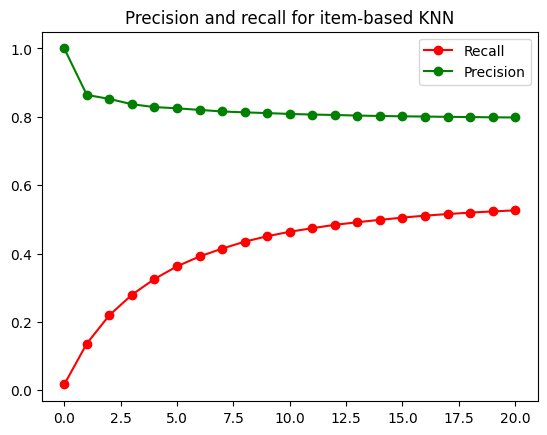

Precision for item-based knn, k=20 0.7981439566140122
Recall for item-based knn, k=20 0.5264430677235229


In [35]:
# Compute precision and recall for k between 0 and 9
precision = []
recall = []
for k in range(21):
    # rating > 3.75 = relevant, rating < 3.75 = irrelevant
    precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.75)
    # Precision and recall can then be averaged over all users
    precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
    recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

# Plot
plt.plot(range(21), recall, 'ro-', label="Recall")
plt.plot(range(21), precision, 'go-', label="Precision")
plt.legend()
plt.title("Precision and recall for item-based KNN")
plt.show();

# Precision and recall at rank 20:
precisions, recalls = precision_recall_at_k(predictions, k=20, threshold=3.75)
print("Precision for item-based knn, k=20", sum(prec for prec in precisions.values()) / len(precisions))
print("Recall for item-based knn, k=20", sum(rec for rec in recalls.values()) / len(recalls))

The graph above allows us to analyse the tradeoff between recall and precision as the k gradually increases from 0 to 20.

We see that the increase in k leads to growth of recall and fall of precision. This is logical, because the more predictions are included, the more likely it is to encounter false positives, which results in a lower precision. A hypothetical perfect model  would strike a perfect balance between high precision and high recall. Alas, in real world, there is almost always a tradeoff between the two.

There is no single best answer as to what k to pick based on the recall and precision. If we cannot maximize both at the same time, we need to decide whether to prioritize recall over precision or vice versa. Would it better to recommend a user a movie they would not like or fail to recommend a movie they would have enjoyed? In other words, what is 'better' - to have the highest fraction of true positives among all predicted positives, or to have fewer false negatives? This is debatable question. If I were a developer of a recommender system for a streaming service, I would prioritize recall. Why recall? Because if a user encounteres a movie they are not interested in (false positive), they would just scroll further. And if they do not encounter a movie they would watch, the streaming service loses potential views and the movie producers do not reach the broad audience they could have reached. That is why it is important to minimize the number of false negatives. It's better to recommend a user more movies and have more false positives in that sample, than to recommend less and miss out on potential views (and, therefore, profit). Yet, there is a drawback to this approach. when seeing too many irrelevant recommendations, a user can become annoyed with the algorith and switch to another streaming service.

Another arguement in favour of this approach would be the fact that, according to the graph, precision does not decrease sharply. In fact, it decreases slower than recall increases. Therefore, if we take a higher recall, we would not have to sacrifise too much of precision.

That being said, I would pick k=20 to maximize recall and show a user top-20 recommendations. Or ever top-50, but 50 is not in the range here.

In [36]:
def precision_recall_algo(algo):
    '''Return precision and recall at k metrics for an algorithm.'''

    # Fit algo on training set
    algo.fit(trainset)

    # Predict on test set
    predictions = algo.test(testset)

    # Compute precision and recall
    precision = []
    recall = []
    for k in range(21):
        precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)
        precision.append( sum(prec for prec in precisions.values()) / len(precisions) )
        recall.append( sum(rec for rec in recalls.values()) / len(recalls) )

    return precision, recall

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


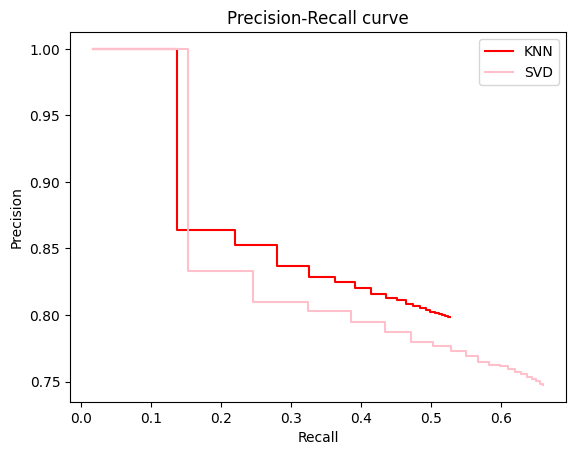

In [37]:
# KNN precision and recall
algo_KNN =  KNNWithMeans(k=20, min_k=0, sim_options=sim_options, verbose=False)
precision_KNN, recall_KNN = precision_recall_algo(algo_KNN)

# SVD (Singular Value Decomposition) precision and recall
algo_SVD = SVD()
precision_SVD, recall_SVD = precision_recall_algo(algo_SVD)

# Plot
plt.step(recall, precision, color='red', where='post', label ='KNN')
plt.step(recall_SVD, precision_SVD, color='pink', where='post', label ='SVD')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve');

The graph above illustrates that the KNN approach is preferrable to the SVD approach. This conclusion stems form the fact that the area under the red line (KNN) is bigger than the area under the pink line (SVD).